# Jupyter Notebook per calcolare una tomografia 2D dell' Italia

### TASK:

Utilizzare i risultati ottenuti in precedenza (tempi di arrivo delle onde P e S a 30 stazioni) e calcolare una distribuzione 2D di velocita' P e S per migliorare il fit ai dati osservati. L' evento sismico e' considerato di posizione nota.

### WORKFLOW:

(0) Selezionare uno degli eventi

(1) Caricare i dati relativi all' evento (tempi di arrivo di onde P ed S)

(2) Utilizzare i tempi di arrivo per determinare una mappa delle velocita' sismiche nella crosta, in Italia


### Import libraries

In [1]:
# Per la gestione dei file
import os

# Per il calcolo numerico
import numpy as np
from math import sqrt

# Per la presentazione grafica dei risultati
import matplotlib
import matplotlib.pyplot as plt

# Per l'analisi dei dati sismici (download compreso)
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.taup import plot_travel_times

# Per le parti interattive del Notebook
from ipywidgets import interact, Layout
import ipywidgets as widgets

from ipywidgets import Layout, Box, VBox, HBox, HTML, Image
from ipywidgets import GridspecLayout
from ipywidgets import ToggleButton

#Per visualizzare immagini
from IPython.display import Image as Image2
import matplotlib.image as image 


### Definizioni

In [2]:
#
#
# Variabili utilizzate nel Notebook per l'analisi
#
#
#Evento sismico
EV_ID=1                                       # 1- Ferrara eq (May2012)

if EV_ID == 1:
    EVENT_NAME="FERRARA_MAINSHOCK"            # LABEL per i file creati
    event_OT="2012-05-20T02:03:53.0"          # Tempo origine dell' evento
    event_lat=44.90                           # Approx longitudine dell' evento
    event_lon=11.24                           # Approx latitudine dell' evento
    # Define event
    event_stat_plot="img/event_1.jpg"         # Mappa dati utilizzati
    
# Stazioni sismiche
NET_CODE="IV"                                 # Nome del network di stazioni utilizzate (cercare in http://www.fdsn.org/networks/)
NAME_and_COORD_stations="input/stations.dat"  # File contenente le informazioni sulle stazioni sismiche utilizzate

# MAP DEFINITION (MIN/MAX for x and y)
xmin=6
xmax=18
ymin=37
ymax=47


#### Calcolare la distanza approssimativa (in kilometri) tra stazioni selezionate e evento 

In [3]:

STAT = []
stla = []
stlo = []
dist = []
index_dist_sorted = []

statfile = open(NAME_and_COORD_stations, 'r')
linestoken=statfile.readlines()
istat=0
for x in linestoken:

    STAT.append(x.split()[0])
    stla.append(x.split()[1])
    stlo.append(x.split()[2])

    if istat > 0:       
        stat0=STAT[istat]
        stla0=float(stla[istat])
        stlo0=float(stlo[istat])
        dist0=(obspy.taup.taup_geo.calc_dist(event_lat,event_lon,stla0,stlo0,6371.0,0.0))*111.19
        dist.append(dist0)

    istat += 1

    
index_dist_sorted = np.argsort(dist)
Nstat=istat-1 
print('Found:',Nstat,'seismic stations in file:',NAME_and_COORD_stations) 
istat=0
while istat < Nstat:
    stat0=STAT[index_dist_sorted[istat]+1]
    dist0=dist[index_dist_sorted[istat]]
    print('%6s%8s%14s%4d%6s' % ('STAT:',stat0,'at distance:',dist0,'in km'))
    istat += 1


Found: 30 seismic stations in file: input/stations.dat
 STAT:    TEOL  at distance:  61 in km
 STAT:    ZCCA  at distance:  64 in km
 STAT:    PRMA  at distance:  74 in km
 STAT:    FNVD  at distance:  81 in km
 STAT:    ROVR  at distance:  84 in km
 STAT:    BRIS  at distance:  85 in km
 STAT:    SALO  at distance:  97 in km
 STAT:     BDI  at distance: 106 in km
 STAT:    MAGA  at distance: 108 in km
 STAT:     CTI  at distance: 131 in km
 STAT:    MABI  at distance: 140 in km
 STAT:     BOB  at distance: 142 in km
 STAT:    PLMA  at distance: 145 in km
 STAT:    CSNT  at distance: 158 in km
 STAT:    BRMO  at distance: 187 in km
 STAT:    STAL  at distance: 189 in km
 STAT:    VARE  at distance: 220 in km
 STAT:     FVI  at distance: 223 in km
 STAT:    PTCC  at distance: 234 in km
 STAT:    CASP  at distance: 236 in km
 STAT:    QLNO  at distance: 237 in km
 STAT:    MONC  at distance: 261 in km
 STAT:    GUMA  at distance: 264 in km
 STAT:    CAMP  at distance: 315 in km
 STAT:   

## (1) Leggere i tempi di arrivo ottenuti in precedenza

In [4]:
kind_of_data="MANUAL"       # Set MANUAL for manual pickings, AUTOMATIC for automatic pickings

if kind_of_data == "AUTOMATIC":
    datafile = './input/' + EVENT_NAME + '.automatic_picking'

if kind_of_data == "MANUAL":
    datafile = './input/' + EVENT_NAME + '.manual_picking'
    
    

statfile = open(datafile, 'r')
STAT = []
stla = []
stlo = []
Ppick = []
Spick = []


linestoken=statfile.readlines()
nstat_sele=0
for x in linestoken:
    nstat_sele+=1
    STAT0=(x.split()[4])
    stla0=float(x.split()[3])
    stlo0=float(x.split()[2])    
    Spick0=float(x.split()[1])
    Ppick0=float(x.split()[0])
    STAT.append(STAT0)
    stla.append(stla0)
    stlo.append(stlo0)
    Spick.append(Spick0)
    Ppick.append(Ppick0)
    print('%3d%10s%8.3f%8.3f%12.2f%12.2f' % (nstat_sele,STAT0,stlo0,stla0,Ppick0,Spick0))
    
min_P_pick = float(min(Ppick))
print('Found', nstat_sele, 'stations with associated picking -- earliest P-arrival:', min_P_pick)

  1      TEOL  11.674  45.362       11.00       22.00
  2       CTI  11.650  46.048       22.00       41.00
  3      CASP  10.865  42.791       35.00       55.00
  4      ZCCA  10.976  44.351       12.00       23.00
  5       BOB   9.448  44.768       25.00       44.00
  6      MABI  10.514  46.055       23.00       41.00
  7      ROVR  11.072  45.647       14.00       29.00
  8      BRMO  10.372  46.476       31.00       52.00
  9      INTR  13.905  42.012       58.73      114.23
 10      PRMA  10.313  44.764       14.00       25.50
 11      FNVD  11.123  44.168       14.00       27.00
 12      BRIS  11.767  44.225       18.00       29.00
 13      SALO  10.524  45.618       17.00       32.00
 14       BDI  10.597  44.062       19.00       34.00
 15      MAGA  10.629  45.775       19.00       34.00
 16      PLMA   9.854  44.050       25.00       44.00
 17      CSNT  11.290  43.473       26.50       46.00
 18      STAL  12.710  46.260       29.00       51.00
 19      VARE   8.770  45.86

### Mappa delle stazioni sismiche selezionate, dell' evento  e delle osservazioni P

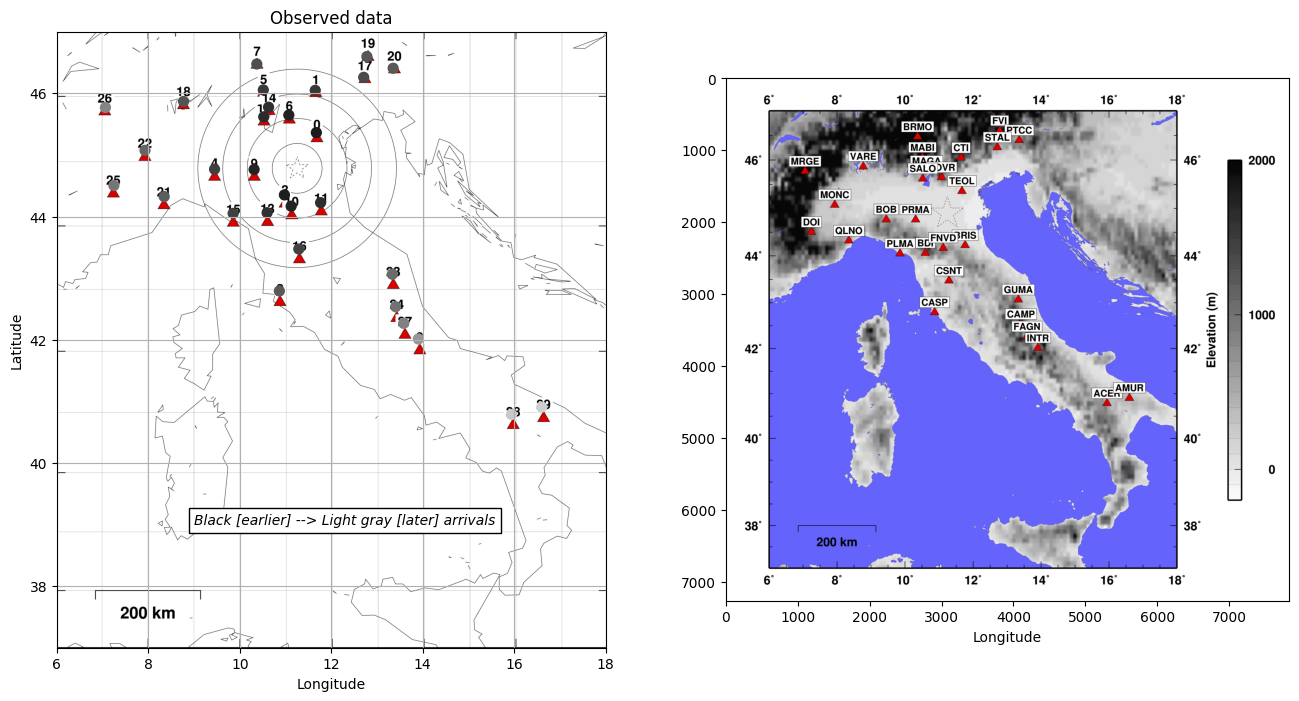

In [5]:
#
# QUESTO SEZIONE SERVE SOLO PER IL PLOT FINALE
xc = []
yc = []
zc = []
wc = []
i=0
while i < nstat_sele:
    a=float(stlo[i])
    b=float(stla[i])
    c=(float(Ppick[i]))
    d=(float(Spick[i]))
    xc.append(a)
    yc.append(b)
    zc.append(c)
    wc.append(d)
    i+=1
# QUESTO SEZIONE SERVE SOLO PER IL PLOT FINALE
#
im1 = plt.imread("img/event_1_no_topo_grid.jpg")
im2 = plt.imread("img/event_1.jpg")
aspect1 = im1.shape[0] / im1.shape[1] * (xmax - xmin)/(ymax - ymin)
aspect2 = im2.shape[0] / im2.shape[1] * (xmax - xmin)/(ymax - ymin)
aspect2 =1.0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.text(9, 39, 'Black [earlier] --> Light gray [later] arrivals', style='italic',bbox={'facecolor': 'w', 'alpha': 1.0})
ax1.title.set_text('Observed data' )
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
ax1.grid()
ax1.scatter(xc, yc, s=50, c=zc, vmin=0,vmax=100, cmap='gray')
ax1.imshow(im1, zorder=0, extent=[xmin, xmax, ymin, ymax], aspect=aspect1)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax2.imshow(im2, aspect=aspect2)
ax2.set_xlabel('Longitude')
plt.show()


## (2) Utilizzare i tempi di arrivo per stimare le velocita' sismiche in alcune zone del modello

#### Average 1D model for P-wave velocity in the Earth' s crust

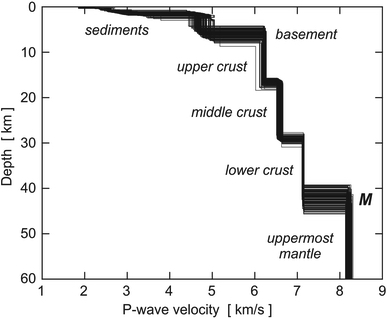

In [6]:
Image2('img/average_P_vel.jpg',width=500)


(Sgroi et al. Sceintific Reports, 2021)

#### Define average P- and S- wave velocities for the model

In [7]:

AVER_P=input('Insert average P-wave velocity for the model [3.0-10.0]:')
aver_P_vel=float(AVER_P)
AVER_S=input('Insert average S-wave velocity for the model [2.0-6.0]:')
aver_S_vel=float(AVER_S)


Insert average P-wave velocity for the model [3.0-10.0]:8.0
Insert average S-wave velocity for the model [2.0-6.0]:4.0


In [8]:

hbox_layout = Layout()
hbox_layout.width = '100%'
hbox_layout.justify_content = 'space-around'

green_box_layout = Layout()
green_box_layout.width = 'auto'
green_box_layout.height = 'auto'
green_box_layout.border = '1px solid green'


def make_box_for_grid(image_widget, fit):

    # Make the green box with the image widget inside it
    boxb = Box()
    boxb.layout = green_box_layout
    boxb.children = [image_widget]

    # Compose into a vertical box
    vb = VBox()
    vb.layout.align_items = 'center'
    vb.children = [boxb]
    return vb


with open('img/event_1_no_topo_grid.jpg', 'rb') as f:
    im_grid = f.read()

boxes = []
ib = Image(value=im_grid)
ib.layout.object_fit = None
ib.layout.margin = '0 0 0 0'
boxes.append(make_box_for_grid(ib, None))

vb = VBox()
vb.layout.align_items = 'center'
hb = HBox()
hb.layout = hbox_layout
hb.children = boxes
vb.children = [hb]

def create_expanded_button(description, button_style):
    return ToggleButton(value=False,
                        description=description, 
                        disabled=False,
                        button_style=button_style, 
                        layout=Layout(height='auto', width='auto'))

grid = GridspecLayout(10, 24)

for i in range(10):
    for j in range(12):
        grid[i, j] = create_expanded_button('LV', '')

grid[:,13:24] = vb

#grid


In [14]:

print('Fit alle osservazioni della mappa 2D selezionata, considerando l\'evento in posizione nota:')
print('(i tasti scuri indicano le zone a bassa velocita\')')


# Define event
x2=event_lon #11.0249              # event_lon from previous JNotebook
y2=event_lat #44.8125              # event_lat from previous JNotebook

#Define approximate OT as arrival time to closest station minus theroretical travel time
x1=float(stlo[1])
y1=float(stla[1])
dist0= sqrt( ((x2-x1)*111.19)**2 + ((y2-y1)*111.19)**2 )
OT_approx= min_P_pick - (dist0/aver_P_vel)



Pvel = []
Svel = []
istat=0    
while istat < nstat_sele:
    
    # Define observation point
    x1=float(stlo[istat])
    y1=float(stla[istat])
    
    # Define area sampled by seismic ray
    if x1 < x2 :
        xb_min = x1-0.5
        xb_max = x2+0.5
    else:
        xb_min = x2-0.5
        xb_max = x1+0.5
    if y1 < y2 :
        yb_min = y1-0.5
        yb_max = y2+0.5
    else:
        yb_min = y2-0.5
        yb_max = y1+0.5
       
    Pvel0=0
    Svel0=0
    hit=0
    hit_low=0
    j=0
    while j < 10:
        y3= ymax - j - 0.5
        k=0
        while k < 12:
            x3=xmin + k + 0.5
            d=abs((x2-x1)*(y1-y3) - (x1-x3)*(y2-y1)) / np.sqrt(np.square(x2-x1) + np.square(y2-y1)) 
            #print(d,x3,xb_min, xb_max, y3, yb_min, yb_max)
            if d < 1.0 and x3 > xb_min and x3 < xb_max and y3 > yb_min and y3 < yb_max:
                hit+=1
                #print(istat, 'traversing grid: ', k, j)
                if grid[j,k].value == True:
                    hit_low+=1
                    Pvel0 = Pvel0 + aver_P_vel - 1.5
                    Svel0 = Svel0 + aver_S_vel - 1.0
                else:
                    Pvel0 = Pvel0 + aver_P_vel
                    Svel0 = Svel0 + aver_S_vel
                
            k+=1
        j+=1
    Pvel0=Pvel0/hit
    Svel0=Svel0/hit
    if hit_low > 0:
        print('Stazione affetta da LV: ', istat, 'Lunghezza raggio sismico: ', hit, 'Zone LV: ', hit_low)
    Pvel.append(Pvel0)
    Svel.append(Svel0)
    istat+=1

# Compute theoretical P-wave travel time considering mean P-velocity

misfit = 0
istat=0
while istat < nstat_sele:
    x1=float(stlo[istat])
    y1=float(stla[istat])
    dist= sqrt( ((x2-x1)*111.19)**2 + ((y2-y1)*111.19)**2 )
    # Define mean P vel for the station
    Pvel0=Pvel[istat]
    # Define mean S vel for the station
    Svel0=Svel[istat]
    theo_P = (1.0/Pvel0) * dist
    obs_P = float(Ppick[istat])
    theo_S = (1.0/Svel0) * dist
    obs_S = float(Spick[istat])
    misfit = misfit + (obs_P - theo_P - OT_approx)**2
    misfit = misfit + (obs_S - theo_S - OT_approx)**2
    istat+=1

print('%s%16.4f\n' % ('\n Misfit for the 2D map:', misfit))


# plt.figure(2,figsize=(18,3))
# plt.plot(x_all,dg_all)
# plt.errorbar(stat_x, stat_grav, yerr=dg_err, fmt='o')
# plt.grid()
# plt.ylabel('Gravity anomaly (mGal)')
# plt.xlim(0,160)
# plt.ylim(-50,200)
# plt.xlabel('x (km)')
# plt.show()
grid

Fit alle osservazioni della mappa 2D selezionata, considerando l'evento in posizione nota:
(i tasti scuri indicano le zone a bassa velocita')
Stazione affetta da LV:  2 Lunghezza raggio sismico:  6 Zone LV:  2
Stazione affetta da LV:  3 Lunghezza raggio sismico:  2 Zone LV:  1
Stazione affetta da LV:  4 Lunghezza raggio sismico:  3 Zone LV:  1
Stazione affetta da LV:  5 Lunghezza raggio sismico:  5 Zone LV:  1
Stazione affetta da LV:  7 Lunghezza raggio sismico:  6 Zone LV:  1
Stazione affetta da LV:  8 Lunghezza raggio sismico:  7 Zone LV:  5
Stazione affetta da LV:  9 Lunghezza raggio sismico:  2 Zone LV:  1
Stazione affetta da LV:  12 Lunghezza raggio sismico:  4 Zone LV:  1
Stazione affetta da LV:  13 Lunghezza raggio sismico:  2 Zone LV:  1
Stazione affetta da LV:  14 Lunghezza raggio sismico:  4 Zone LV:  1
Stazione affetta da LV:  15 Lunghezza raggio sismico:  3 Zone LV:  1
Stazione affetta da LV:  16 Lunghezza raggio sismico:  2 Zone LV:  1
Stazione affetta da LV:  18 Lunghezza

GridspecLayout(children=(ToggleButton(value=False, description='LV', layout=Layout(grid_area='widget001', heig…

####  Dove trovare altri terremoti:

https://www.emsc-csem.org/Earthquake/?filter=yes

In [15]:
%load_ext watermark
%watermark -v -p numpy,matplotlib,obspy,ipywidgets

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 8.9.0

numpy     : 1.24.2
matplotlib: 3.6.3
obspy     : 1.4.0
ipywidgets: 8.0.4

